In [1]:
import torch
import numpy as np
import pandas as pd
import requests
import enum
from datetime import date as dt



import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from data_retrieval import retrieve_data_from_url, prepare_data
import plotly.graph_objects as go
import plotly.offline as py

import wandb

In [ ]:
run.finish()

In [2]:
# CONFIGURATION Parameters
WANDB_MODE = 'online'
run_name = "smooth_jazz_5"
MODEL_PATH = "kaiharuto/capstone/smooth_jazz_5:v0"
DATASET_PATH = 'kaiharuto/capstone/covid-data:v4'
MODEL_FILE_NAME = "epoch=23.ckpt"
# DATASET_VERSION = 'v4'
BUILD_NEW_DATASET = False
RUN_CONFIG= "run_config.yml"

In [3]:
#SETUP DATA
run = wandb.init(project="capstone", name="predict", mode=WANDB_MODE, job_type="prediction", reinit=True, config='run_config.yml')
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'
df = retrieve_data_from_url(URL)
data, x_df, info = prepare_data(df)

#get training data to find last date we had in training
data_artifact = run.use_artifact(DATASET_PATH, type="dataset")
train_df_path = "artifacts/covid-data:v4"
train_df_file = train_df_path + "/covid_json"

train_df = pd.read_json(train_df_file, orient="index")

train_data, x_df, info = prepare_data(train_df)

wandb: Currently logged in as: kaiharuto (use `wandb login --relogin` to force relogin)


In [4]:
#SETUP AND LOAD MODEL
model_artifact = run.use_artifact(MODEL_PATH, type='model')
model_artifact_dir = model_artifact.download()
model_file = model_artifact_dir + "/" + MODEL_FILE_NAME


<Artifact QXJ0aWZhY3Q6MTI4NTM5Nw==>

In [5]:
model = TemporalFusionTransformer.load_from_checkpoint(model_file)

/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/.venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
predict_data = data.copy(deep=True)

In [7]:
indices_to_drop = predict_data.groupby("location").agg("size").loc[
   (predict_data.groupby("location").agg("size") < run.config.max_encoder_length)
    |
    (predict_data.groupby("location").agg("size") < run.config.max_pred_length)
].index.to_list()

In [8]:
indices_to_drop

['AIA',
 'BMU',
 'CYM',
 'FLK',
 'FRO',
 'FSM',
 'GGY',
 'GIB',
 'GRL',
 'HKG',
 'IMN',
 'JEY',
 'MAC',
 'MHL',
 'MSR',
 'OWID_NCY',
 'SHN',
 'SLB',
 'TCA',
 'VUT',
 'WSM']

In [9]:
#set training cutoff programatically
run.config.training_cutoff = data['time_idx'].max() - run.config.max_pred_length

# adjust data to match training format
predict_data.drop(index=predict_data.loc[predict_data.location.isin(indices_to_drop)].index, inplace=True)
predict_data = predict_data.sort_values('location')

# make new columns indicating what will be imputed
cols_with_missing = (col for col in [*run.config.static_reals, *run.config.time_varying_known_reals,
                                     run.config
                                     .targets]
                                 if predict_data[col].isnull().any())
for col in cols_with_missing:
    predict_data[col + '_was_missing'] = predict_data[col].isnull()

predict_data[[*run.config.static_reals, *run.config.time_varying_known_reals, run.config.targets]] = predict_data[[*run.config.static_reals, *run.config.time_varying_known_reals, run.config.targets]].fillna(0) 


impute_dummies = [col for 
                  col in predict_data.columns if col.endswith("_was_missing")]

predict_data[impute_dummies] = predict_data[impute_dummies].astype("str").astype("category")

# if the dataset still contains missing values for the target, count them and drop them 
missing_targets = predict_data.loc[predict_data[run.config.targets].isna()][["location","date"]].copy(deep=True)
predict_data.drop(index=missing_targets.index, inplace=True)

# small_samples = 
# predict_data.drop(index=)

In [62]:
predict_data.loc[predict_data[run.config.targets].isna()]

,location,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,...,life_expectancy_was_missing,human_development_index_was_missing,extreme_poverty_was_missing,female_smokers_was_missing,male_smokers_was_missing,stringency_index_was_missing,new_tests_smoothed_was_missing,new_vaccinations_smoothed_was_missing,new_deaths_smoothed_was_missing,new_cases_smoothed_was_missing


In [94]:
train_data.date.max()

Timestamp('2021-02-19 00:00:00')

In [238]:
t_predict_data = predict_data.drop(index=predict_data.loc[predict_data.location.isin(indices_to_drop)].index).sort_values("location")

In [10]:
new_index = dict(tuple(zip(predict_data.location.unique(), range(0, predict_data.location.nunique()))))

In [ ]:
new_index

In [ ]:
model.hparams["embedding_labels"]["location"]

In [11]:
# select last 180 days 
encoder_data = predict_data[lambda x: x.time_idx > x.time_idx.max() - run.config.max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices

# kharu: we should also definitely not forward fill
last_data = predict_data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.DateOffset(days=i)) for i in range(1, run.config.max_pred_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 356 + decoder_data["date"].dt.day
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)


#make time series
# pred_ts = TimeSeriesDataSet(
#     predict_data,
#     group_ids=["location"],
#     time_idx="time_idx",
#     static_categoricals=['location', 'continent', 'tests_units'], 
#     static_reals = run.config.static_reals,
#     time_varying_known_categoricals=['month', *impute_dummies], #allow for missings to be flagged on country-level over time - needs to be assumed in forecasts
#     time_varying_known_reals=run.config.time_varying_known_reals,
#     target_normalizer=GroupNormalizer(groups=['location'], transformation=run.config.transformation),
#     add_relative_time_idx=True,
#     add_target_scales=True,
#     add_encoder_length=True,
#     target= run.config.targets,
#     max_encoder_length=run.config.max_encoder_length,
#     max_prediction_length=run.config.max_pred_length,
#     predict_mode=True,
#     allow_missings=True
# )

In [17]:

#make time series
pred_ts = TimeSeriesDataSet(
    new_prediction_data,
    group_ids=["location"],
    time_idx="time_idx",
    static_categoricals=['location', 'continent', 'tests_units'], 
    static_reals = run.config.static_reals,
    time_varying_known_categoricals=['month', *impute_dummies], #allow for missings to be flagged on country-level over time - needs to be assumed in forecasts
    time_varying_known_reals=run.config.time_varying_known_reals,
    target_normalizer=GroupNormalizer(groups=['location'], transformation=run.config.transformation),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    target= run.config.targets,
    max_encoder_length=run.config.max_encoder_length,
    max_prediction_length=run.config.max_pred_length,
    predict_mode=True,
    allow_missings=True,
)

In [13]:
vars(pred_ts)['index'].group_id.nunique()

NameError: name 'pred_ts' is not defined

In [244]:
len(model.hparams['embedding_labels']['location'])

212

In [18]:
test_preds, new_x = model.predict(pred_ts, mode="raw", return_x=True)

In [ ]:
vars(model)
new_predictions

In [14]:
data.loc[data.location == "AND"].new_cases_smoothed.max()

112.429

In [12]:
new_predictions, new_x = model.predict(new_prediction_data, mode="raw", return_x=True)

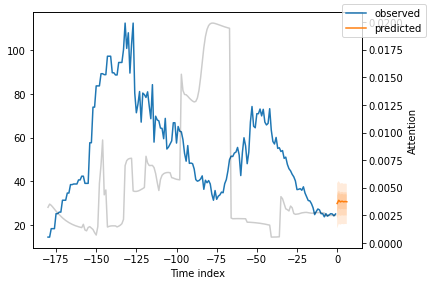

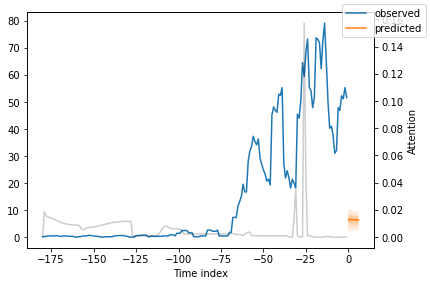

In [14]:
for country in ("AND", "SYC"):
    model.plot_prediction(new_x, new_predictions, idx=new_index[country], show_future_observed=False);

In [17]:
# taken from pytorch-forecasting source
# https://github.com/jdb78/pytorch-forecasting/blob/48179d20ec563511ef71a70406b0506a4459d4e1/pytorch_forecasting/utils.py#L264
from typing import List,  Any
def to_list(value: Any) -> List[Any]:
    """
    Convert value or list to list of values.
    If already list, return object directly
    Args:
        value (Any): value to convert
    Returns:
        List[Any]: list of values
    """
    if isinstance(value, (tuple, list)) and not isinstance(value, rnn.PackedSequence):
        return value
    else:
        return [value]

In [15]:
quantiles = model.loss.to_quantiles(new_predictions["prediction"])[0]
# quantile_list[0].detach().cpu()[0, : new_x["decoder_lengths"][0]].tolist()
# pred_lower = quantile_list[0, : new_x["decoder_lengths"][0]]
quantiles_t = torch.transpose(quantiles[:run.config.max_pred_length, :new_x["decoder_lengths"][0]], 0, 1).tolist()
y_lower = quantiles_t[0]
y_upper = quantiles_t[-1]

In [159]:
y_lower, y_upper

([5.32181517278775e-14,
  3.04911098539945e-13,
  3.5246393477461613e-13,
  3.802388905040782e-13,
  3.9580239584967314e-13,
  4.140448292382082e-13,
  4.574813835048208e-13],
 [90.87322998046875,
  91.5642318725586,
  91.69395446777344,
  91.64676666259766,
  91.6489028930664,
  91.65480041503906,
  91.68950653076172])

In [34]:
pred_list = model.loss.to_prediction(new_predictions["prediction"])
y_pred = pred_list[0].detach().cpu()[: new_x["decoder_lengths"][0]].tolist()

In [33]:
pred_list

tensor([34.9402, 36.4686, 36.6140, 36.6300, 36.6575, 36.7201, 37.3399])

In [161]:
raw_pred_list = to_list(new_predictions["prediction"][0])
raw_pred_list[0].detach().cpu()[: new_x["decoder_lengths"][0]].tolist()[0]

[5.32181517278775e-14,
 1.2652075290679932,
 14.060822486877441,
 35.0987548828125,
 60.756797790527344,
 69.37857055664062,
 90.87322998046875]

In [109]:
y_pred

[35.0987548828125,
 36.448486328125,
 36.592674255371094,
 36.60822296142578,
 36.63116455078125,
 36.65843963623047,
 36.727928161621094]

In [79]:
day_zero = pd.Timestamp(predict_data.date.max())

In [80]:
pd.Timestamp(day_zero)

Timestamp('2021-03-07 00:00:00')

In [37]:
new_x["decoder_lengths"].tolist()[0]

7

In [38]:
new_x["encoder_lengths"].tolist()[0]

180

In [39]:
x = pd.date_range(day_zero - pd.DateOffset(days=run.config.max_encoder_length), day_zero + pd.DateOffset(days=run.config.max_pred_length-1), freq="D").to_list()
x_rev = x[::-1]

In [40]:
y_known = new_x['encoder_target'][0].tolist()

In [41]:
y_known +=(run.config.max_pred_length*[np.nan])
len(y_known)

187

In [42]:
y_pred = (run.config.max_encoder_length*[np.nan]) + y_pred
y_upper = (run.config.max_encoder_length*[np.nan]) + y_upper
y_lower =  (run.config.max_encoder_length*[np.nan]) + y_lower
len(y_pred), len(y_upper), len(y_lower)

(187, 187, 187)

In [71]:
attention = new_predictions['attention']
len(attention[0])

7

In [96]:
last_training_date = train_data.date.max()

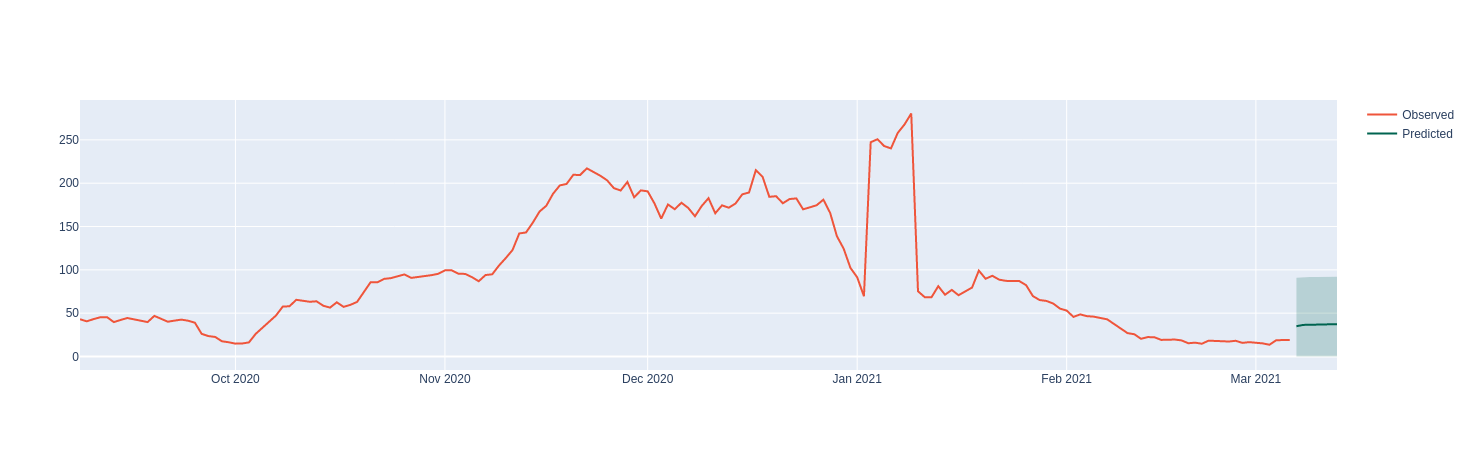

In [81]:


x = pd.date_range(day_zero - pd.DateOffset(days=run.config.max_encoder_length), day_zero + pd.DateOffset(days=run.config.max_pred_length-1), freq="D").to_list()
x_rev = x[-1::-1]

# Line 1
y1 = y_known
y1_upper = y_upper
y1_lower = y_lower
y1_lower = y1_lower[-1::-1]



fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False

))

fig.add_trace(go.Scatter(
    x=x,
    y=y_known,
    name="Observed",
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=x, 
    y=y_pred,
    line_color='rgb(0,100,80)',
    name='Predicted',
))

fig.show()

In [50]:
iso_codes = pd.read_csv('iso3.csv')

In [86]:
country_to_iso = {country[0] : country[1] for country in  iso_codes.to_records(index=False)}

In [83]:
type(new_predictions)

dict

In [220]:
from pytorch_forecasting.models import BaseModel
from pandas import DataFrame, Timestamp
from plotly.graph_objects import Figure
from typing import Dict, Any

def plot_country_prediction(model: BaseModel, predictions: Dict[str,Any], x: Dict[str,Any], country_iso3: str, 
                            country_index: Dict[str,int], day_zero: Timestamp, train_end: Timestamp=None, title: str="") -> Figure:
    """Add Docstring"""
    
  # these will be the same for all time series
    encoder_length: int = x["encoder_lengths"].tolist()[0]
    decoder_length: int = x["decoder_lengths"].tolist()[0]

  # get index for country
    idx = country_index[country_iso3]
    
  # get predictions and quantiles for country
    quantiles = model.loss.to_quantiles(new_predictions["prediction"])[idx]
    quantiles_t = torch.transpose(quantiles[:decoder_length, :new_x["decoder_lengths"][idx]], 0, 1).tolist()
    y_lower = quantiles_t[0]
    y_upper = quantiles_t[-1]
    
    pred_list = model.loss.to_prediction(new_predictions["prediction"])
    y_pred = pred_list[idx].detach().cpu()[: new_x["decoder_lengths"][idx]].tolist()
    
    y_known = new_x['encoder_target'][idx].tolist()
    
  # prepare ys and xs for correct display
    x = pd.date_range((day_zero - pd.DateOffset(days=encoder_length)).strftime("%Y-%m-%d"), 
                    (day_zero + pd.DateOffset(days=decoder_length-1)).strftime("%Y-%m-%d"), freq="D").to_list()
    y_known_p = y_known + (decoder_length*[np.nan])
    y_pred_p = (encoder_length*[np.nan]) + y_pred
    y_upper_p = (encoder_length*[np.nan]) + y_upper
    y_lower_p =  (encoder_length*[np.nan]) + y_lower

  # build plot
    y1 = y_known_p
    y1_upper = y_upper_p
    y1_lower = y_lower_p.copy()
    y1_lower = y1_lower[-1::-1]



    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=x+x_rev,
        y=y1_upper+y1_lower,
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line_color='rgba(255,255,255,0)',
        showlegend=False

    ))

    fig.add_trace(go.Scatter(
        x=x,
        y=y1,
        name="Observed",
        showlegend=True
    ))

    fig.add_trace(go.Scatter(
        x=x, 
        y=y_pred_p,
        line_color='rgb(0,100,80)',
        name='Predicted',
    ))
    
    fig.update_layout(
    title=title,
    xaxis_title="",
    yaxis_title="New Cases (7-day Avg.)",
    )
    
    if train_end:
        fig.add_vline(
            x=train_end,
            line_dash="dash",
            line_width=2,
            line_color="purple",
#             annotation_text = "End of Model Training Data",
#             annotation_position = "bottom right"
        )
        
        fig.add_annotation(
            x = train_end, #+ pd.DateOffset(days=2),
            y = max(y_known),
            text = "End of Model Training Data",
            showarrow=False,
            xshift= -80
            
        )

    return fig
    

In [221]:
figure = plot_country_prediction(model, new_predictions, new_x, country_to_iso["Austria"], new_index, day_zero, last_training_date, "Austria")

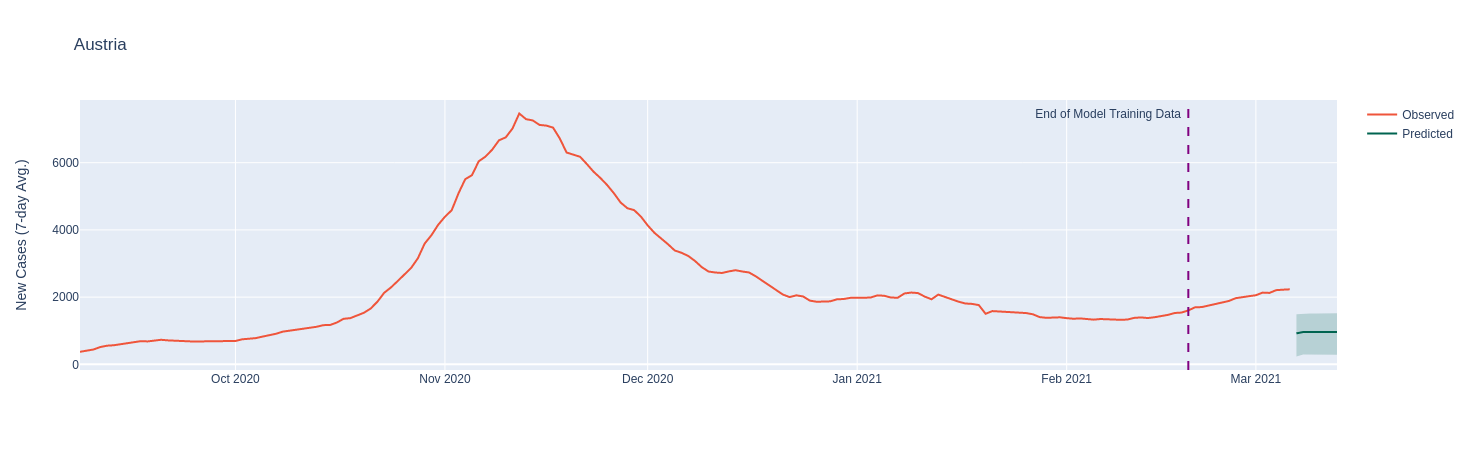

In [222]:
figure.show();

In [107]:

# raw predictions
new_raw_predictions, new_x = model.predict(new_prediction_data, mode="prediction", return_x=True)

# preds for act_vs_pred

predictions, x = model.predict(new_prediction_data, return_x=True)
predictions_vs_actuals = model.calculate_prediction_actual_by_variable(x, predictions)


/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:773: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 5 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'AIA'}, {'__group_id__location': 'MAC'}, {'__group_id__location': 'OWID_NCY'}, {'__group_id__location': 'SHN'}, {'__group_id__location': 'TCA'}]
  warnings.warn(
/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:773: UserWarning: If predicting,

In [108]:
# plot raw
for idx in range(10):  # plot 10 examples
    model.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

IndexError: too many indices for tensor of dimension 2

In [64]:
len(new_raw_predictions[0])

7

In [99]:
new_raw_predictions

tensor([[  44.6860,   46.2857,   46.4774,  ...,   46.6484,   46.7894,
           47.0997],
        [  48.8671,   51.1701,   52.2174,  ...,   52.3433,   52.4251,
           52.5519],
        [ 206.2129,  214.3273,  217.0233,  ...,  216.7752,  217.3552,
          218.6143],
        ...,
        [2751.5625, 2273.8352, 2324.7422,  ..., 2718.1099, 2731.3455,
         2745.5928],
        [1000.6564, 1204.4570, 1212.8893,  ..., 1210.9641, 1209.7612,
         1208.4645],
        [ 100.1975,  113.5716,  108.7096,  ...,  106.0265,  105.8136,
          106.1541]])

In [63]:
decoder_data.nunique()

location                                 199
date                                       7
total_cases                              198
new_cases                                146
total_cases_per_million                  197
                                        ... 
stringency_index_was_missing               2
new_tests_smoothed_was_missing             2
new_vaccinations_smoothed_was_missing      2
new_deaths_smoothed_was_missing            2
new_cases_smoothed_was_missing             2
Length: 80, dtype: int64

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x522 with 1 Axes>,
 'encoder_variables': <Figure size 504x630 with 1 Axes>,
 'decoder_variables': <Figure size 504x630 with 1 Axes>}

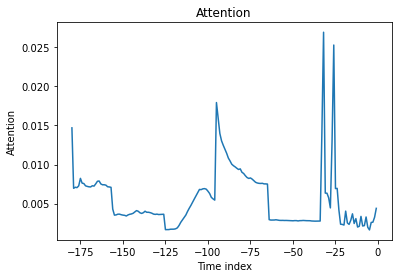

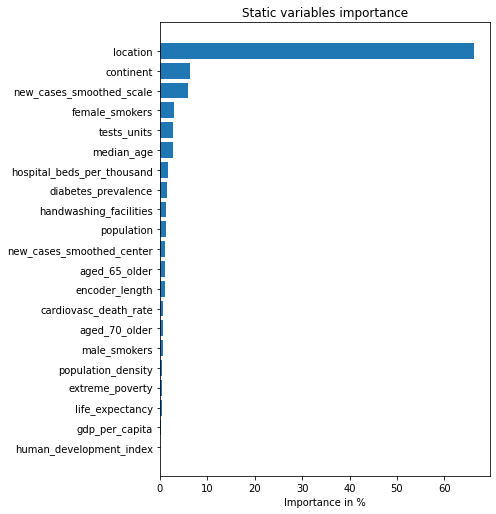

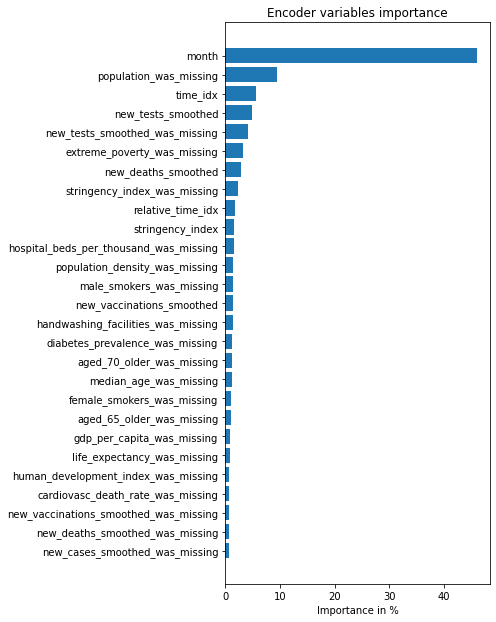

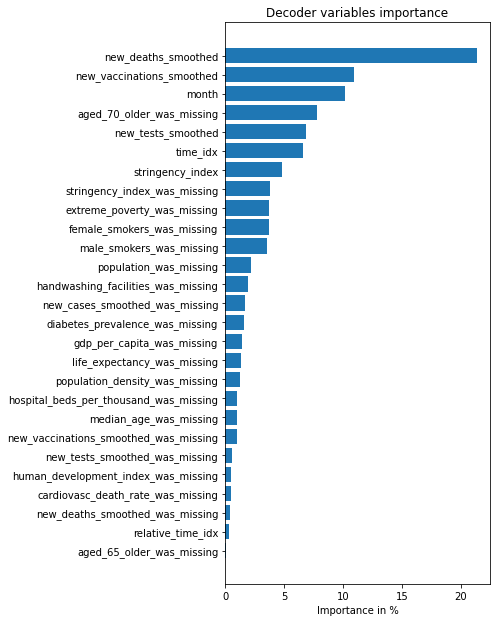

In [109]:
interpretation = model.interpret_output(new_predictions, reduction="sum")
model.plot_interpretation(interpretation)

/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/models/base_model.py:1048: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**kwargs)


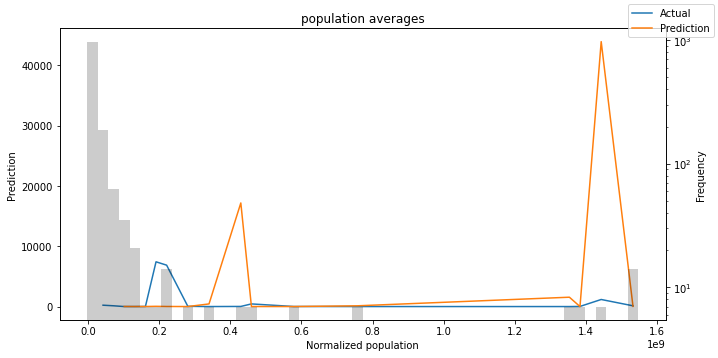

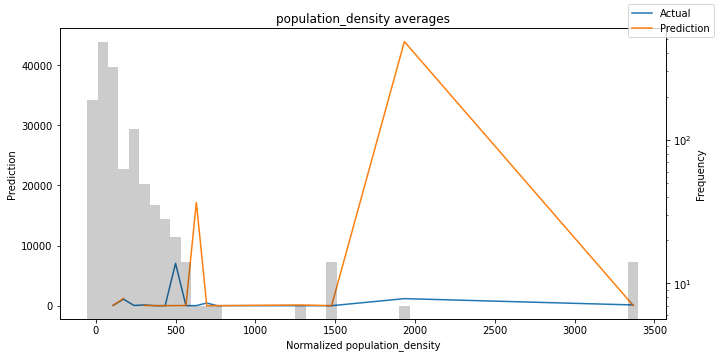

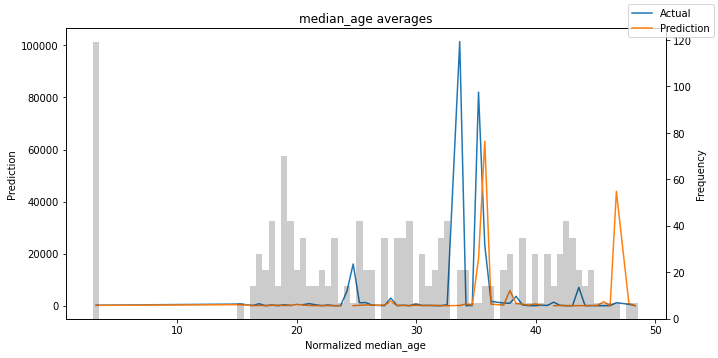

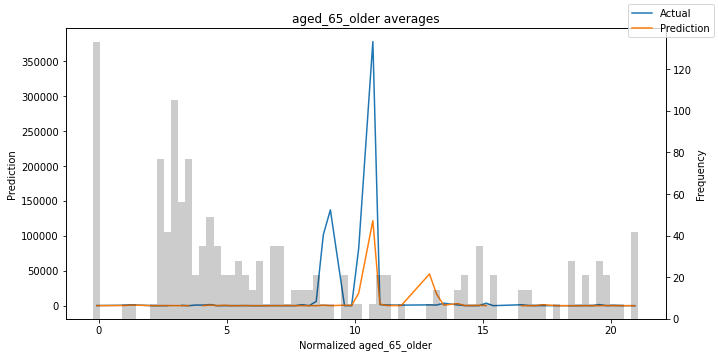

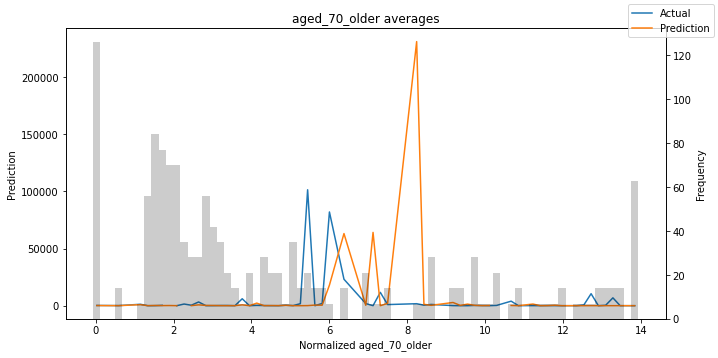

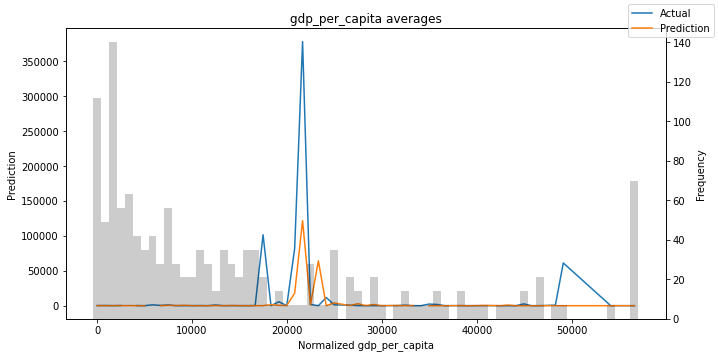

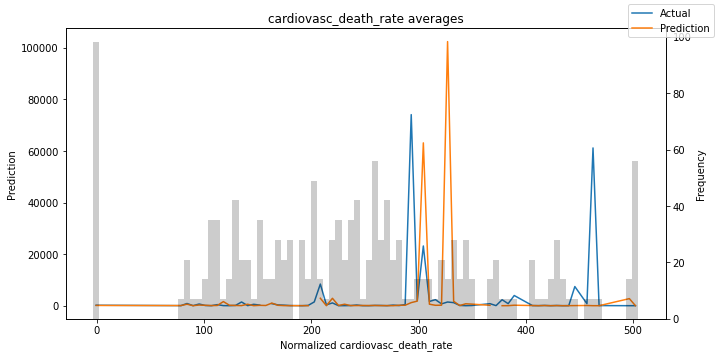

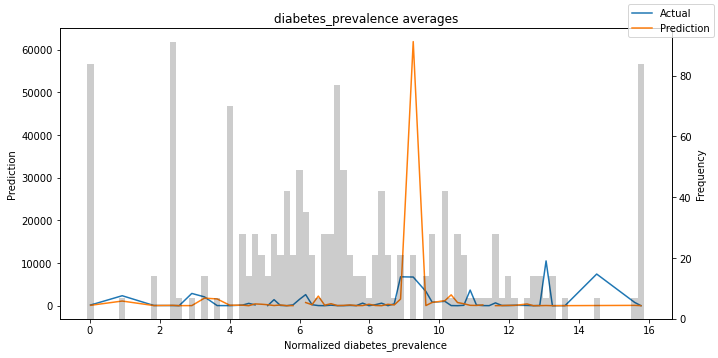

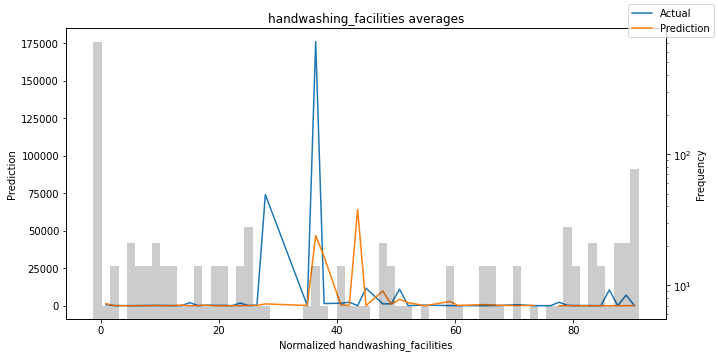

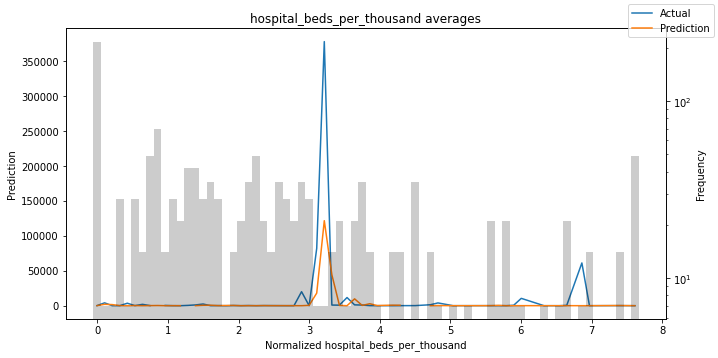

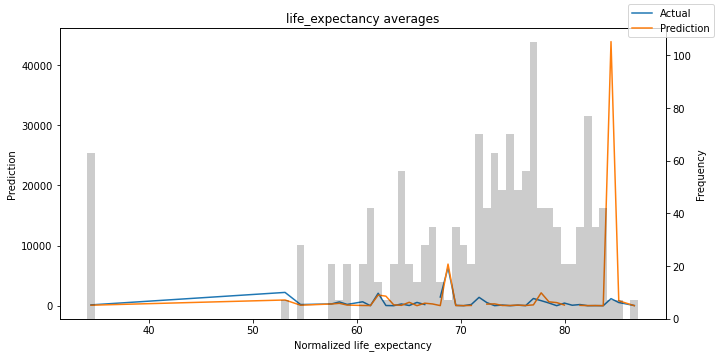

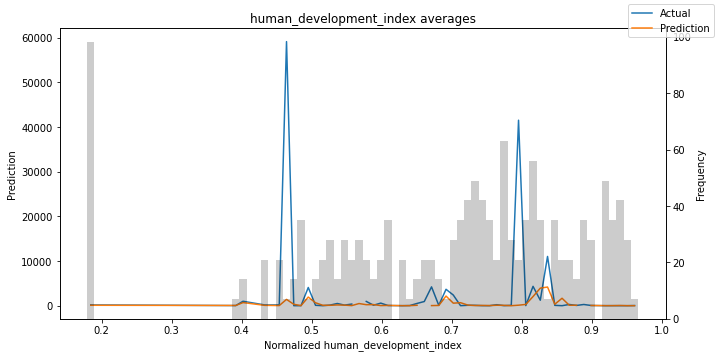

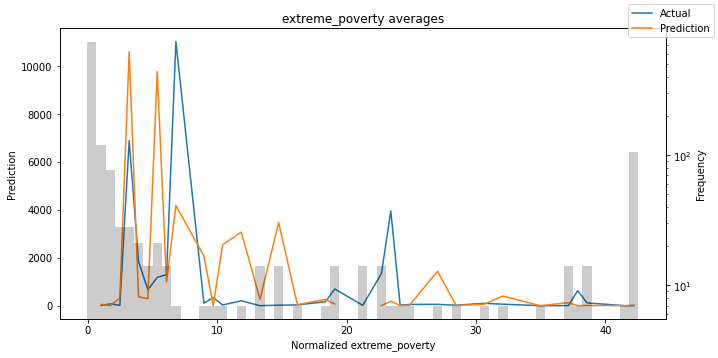

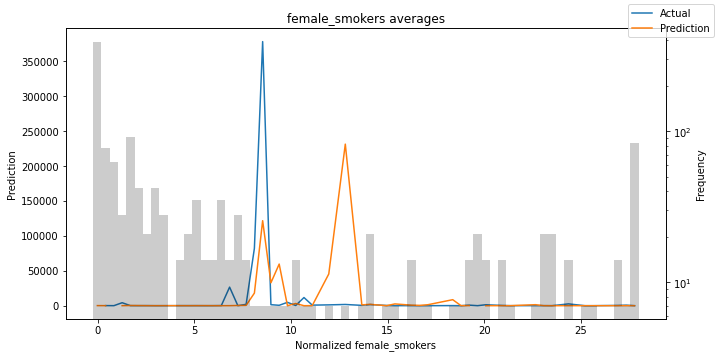

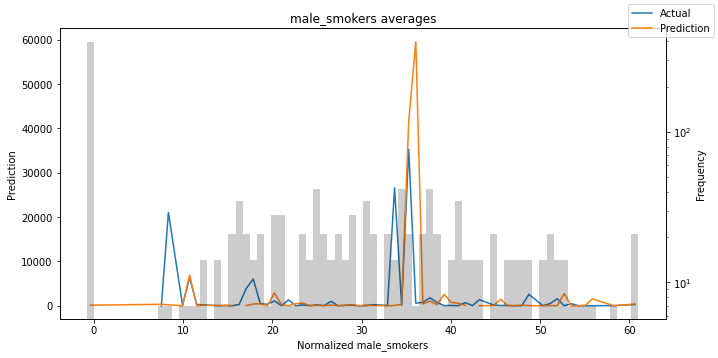

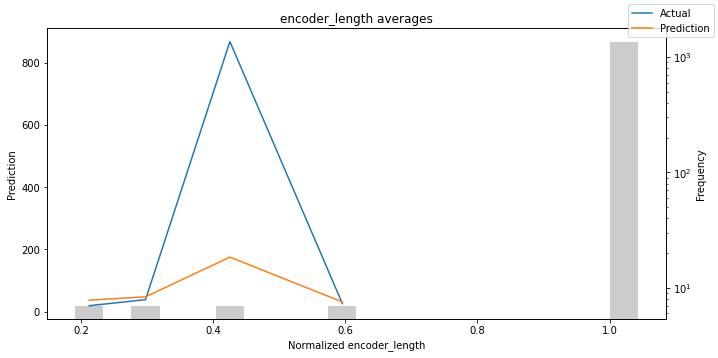

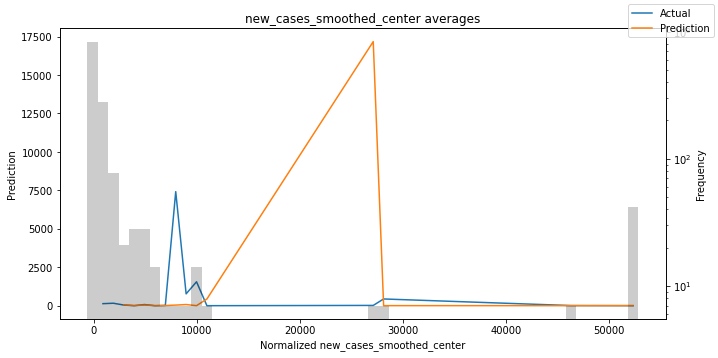

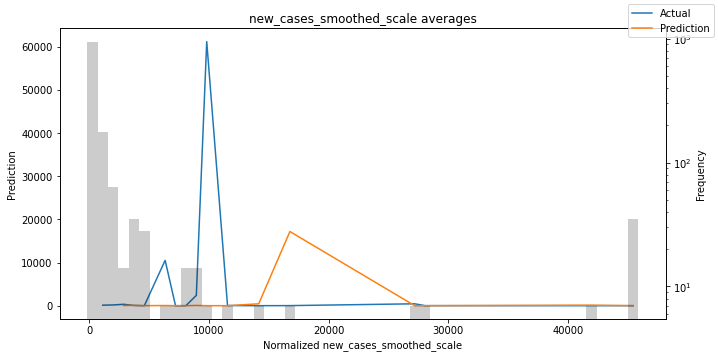

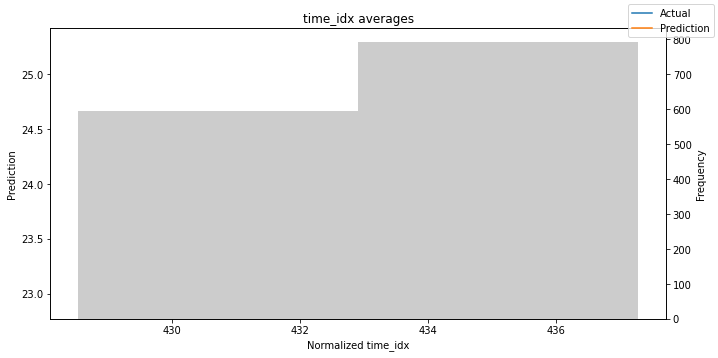

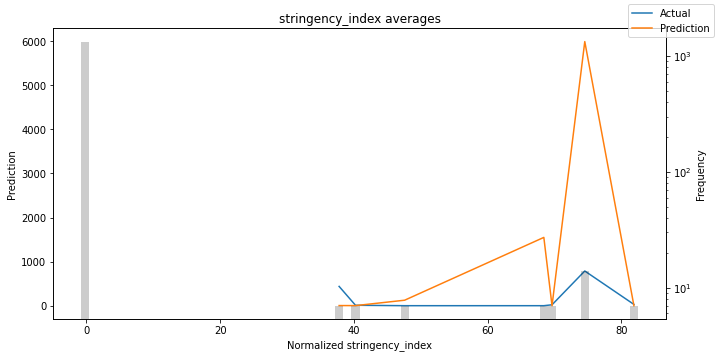

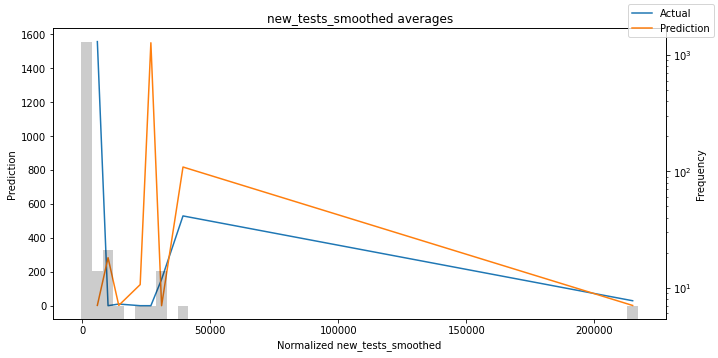

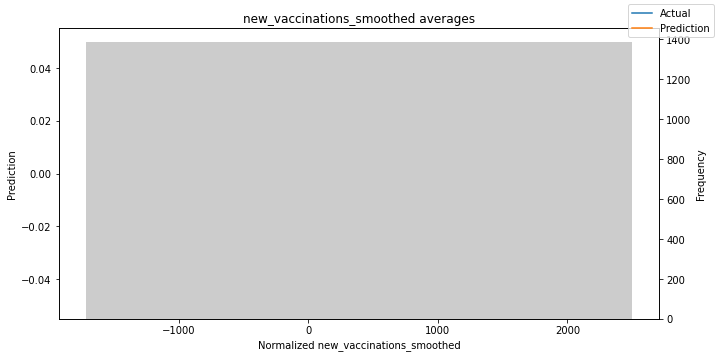

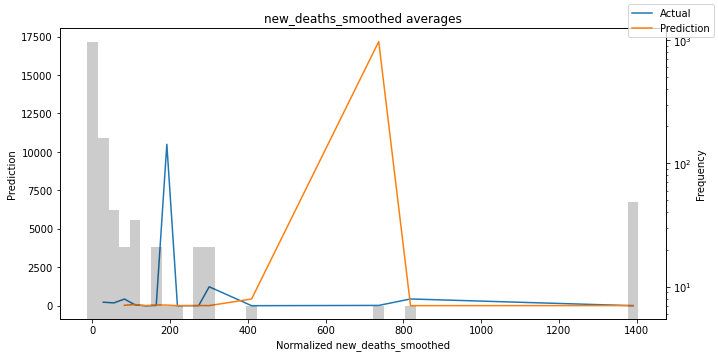

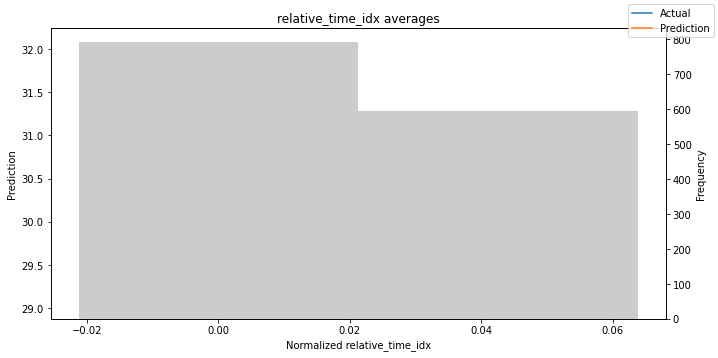

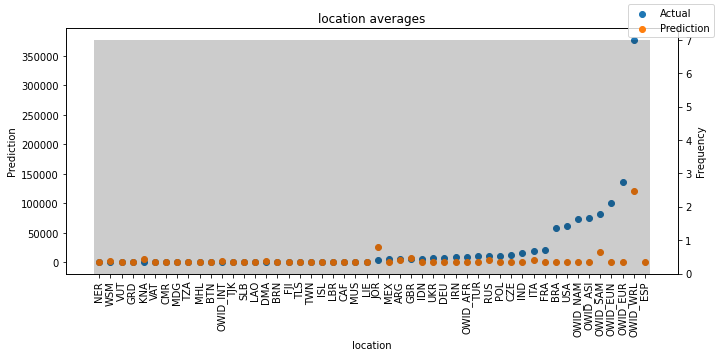

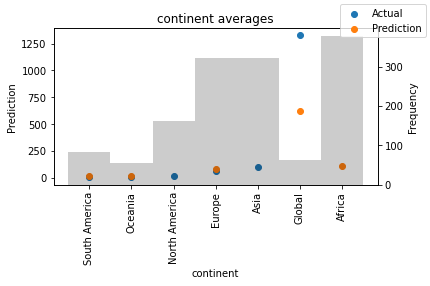

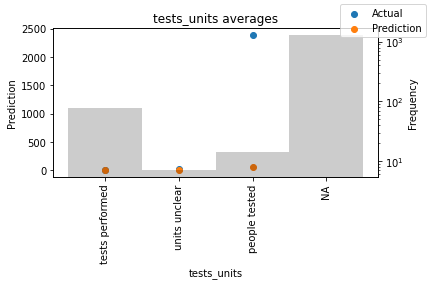

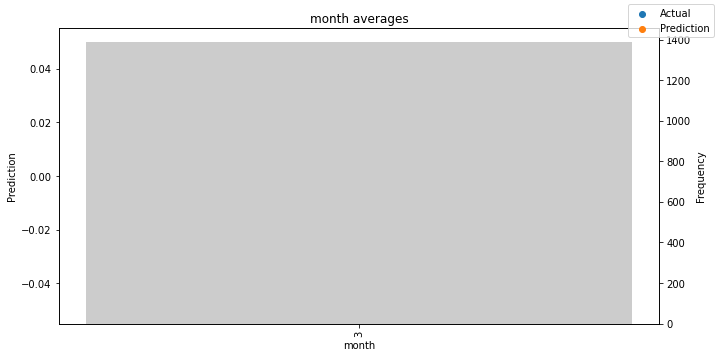

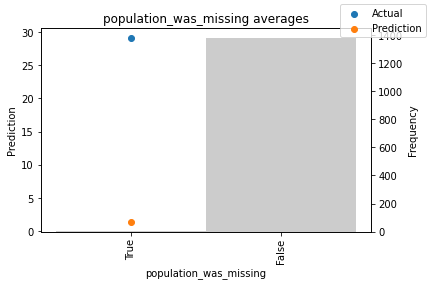

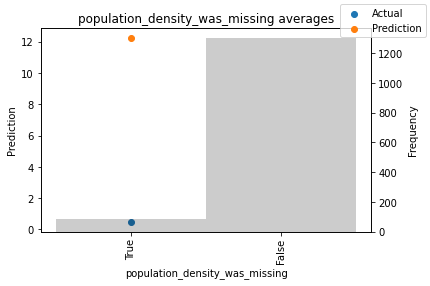

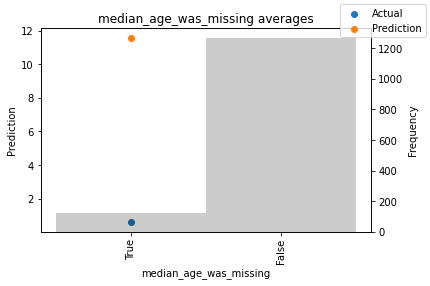

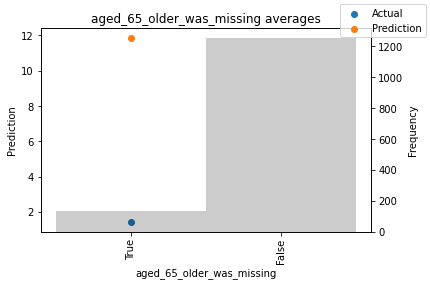

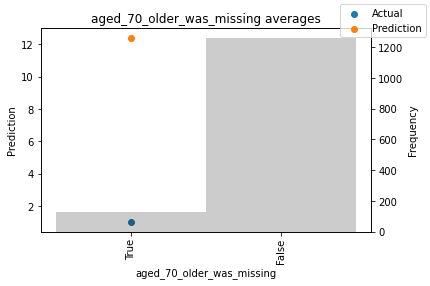

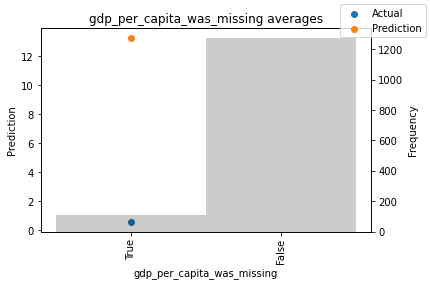

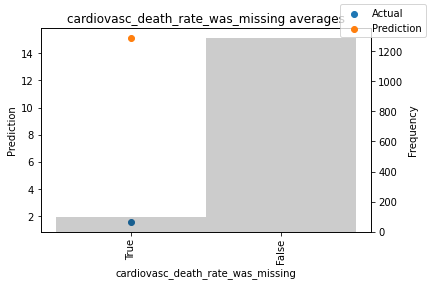

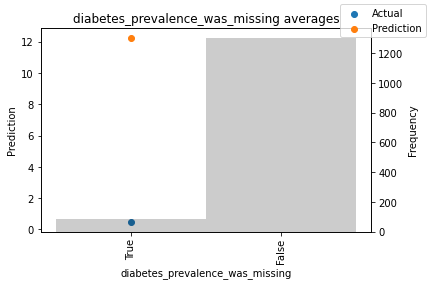

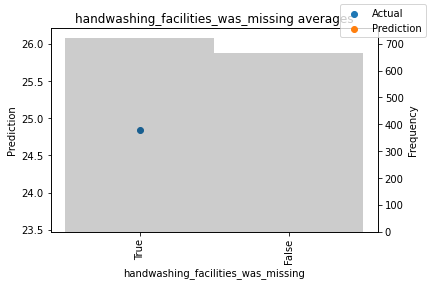

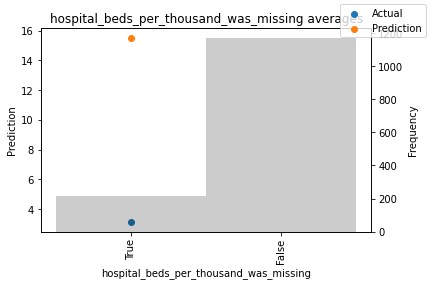

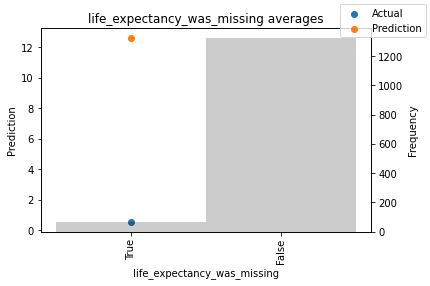

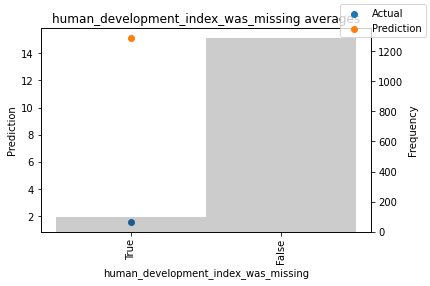

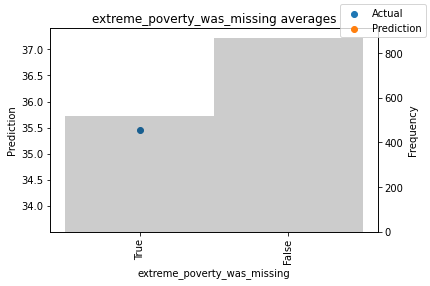

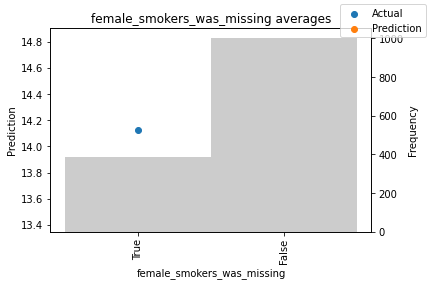

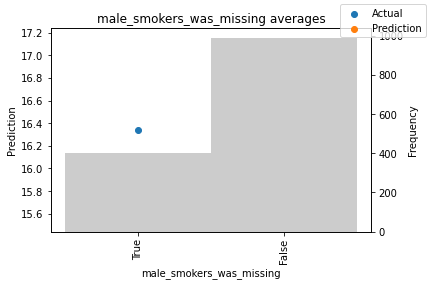

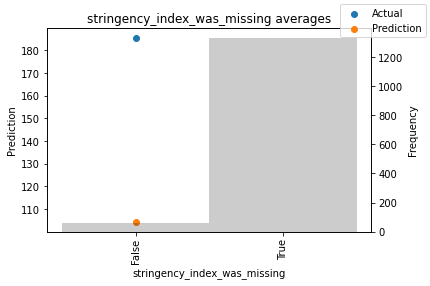

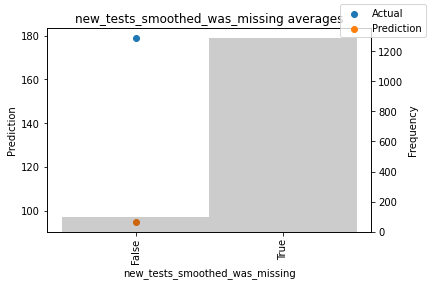

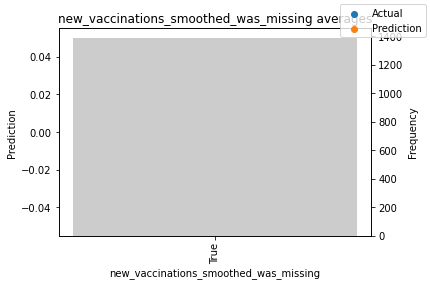

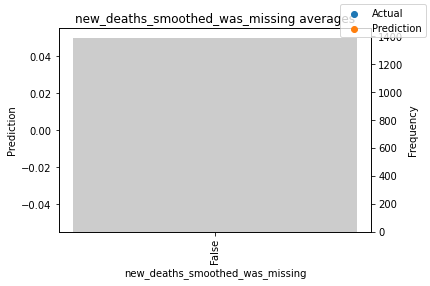

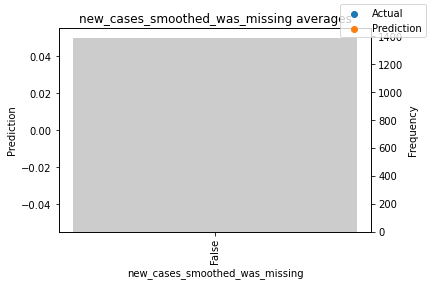

In [110]:
# plot comparison
model.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [26]:
predict_data.loc[data.location == "AFG"].sort_values('date')

,location,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,...,life_expectancy_was_missing,human_development_index_was_missing,extreme_poverty_was_missing,female_smokers_was_missing,male_smokers_was_missing,stringency_index_was_missing,new_tests_smoothed_was_missing,new_vaccinations_smoothed_was_missing,new_deaths_smoothed_was_missing,new_cases_smoothed_was_missing
0,AFG,2020-02-24,1.0,1.0,0.026,0.026,8.33,0.000,0.000,NaN,...,False,False,True,True,True,False,True,True,True,True
1,AFG,2020-02-25,1.0,0.0,0.026,0.000,8.33,0.000,0.000,NaN,...,False,False,True,True,True,False,True,True,True,True
2,AFG,2020-02-26,1.0,0.0,0.026,0.000,8.33,0.000,0.000,NaN,...,False,False,True,True,True,False,True,True,True,True
3,AFG,2020-02-27,1.0,0.0,0.026,0.000,8.33,0.000,0.000,NaN,...,False,False,True,True,True,False,True,True,True,True
4,AFG,2020-02-28,1.0,0.0,0.026,0.000,8.33,0.000,0.000,NaN,...,False,False,True,True,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,AFG,2021-02-18,55557.0,17.0,1427.161,0.437,0.00,19.571,1.571,0.503,...,False,False,True,True,True,True,True,True,False,False
361,AFG,2021-02-19,55575.0,18.0,1427.623,0.462,0.00,18.571,0.857,0.477,...,False,False,True,True,True,True,True,True,False,False
362,AFG,2021-02-20,55580.0,5.0,1427.752,0.128,0.00,15.286,0.429,0.393,...,False,False,True,True,True,True,True,True,False,False
363,AFG,2021-02-21,55604.0,24.0,1428.368,0.617,0.00,16.000,0.714,0.411,...,False,False,True,True,True,True,True,True,False,False
